<a href="https://colab.research.google.com/github/sakalaharshith/Leaf_Disease_Detection_Image_Classification/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# checking whether GPU'S are alloted or not
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.layers.core import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow import keras
#import keras_tuner as kt
import cv2
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support
import seaborn as sns
import os



In [ ]:
# Unzipping dataset file
from zipfile import ZipFile
foldername_large_dataset="/content/dataset_whole_image_classification.zip"
with ZipFile(foldername_large_dataset,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
# Unzipping dataset(white background) file
from zipfile import ZipFile
foldername_without_dataset="/content/without_background.zip"
with ZipFile(foldername_without_dataset,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
# Display example of Plant Village Dataset 
img = cv2.imread('apple_rot.jpg', cv2.IMREAD_UNCHANGED)
 

dim = (180, 180)
  
# resize image
resized = cv2.resize(img, dim,interpolation=cv2.INTER_AREA)

In [ ]:
# Saving path for image dataset
import pathlib
data_directory_full_dataset=pathlib.Path("/content/dataset_whole_image_classification")


In [ ]:
# Saving path for image dataset(white background)
data_directory_without_background=pathlib.Path("/content/without_background")

In [ ]:
# Collecting training data and changing resolution of each image
img_height=224
img_width=224
batch_size=32
training_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_full_dataset,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)


Found 927 files belonging to 6 classes.
Using 742 files for training.


In [ ]:
# saving and display class names for further use
class_names=training_data.class_names
print(class_names)

['Apple_Black_rot', 'Apple_healthy', 'Grape_Black_rot', 'Grape_healthy', 'Potato_Late_blight', 'Potato_healthy']


In [ ]:
# Normalising data for fast training
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label
training_data = training_data.map(process)


In [ ]:
# Collecting testing data 
testing_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_full_dataset,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)
testing_data=testing_data.map(process)

Found 927 files belonging to 6 classes.
Using 185 files for validation.


In [ ]:
# Model check point for saving best epoch as final model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/sample_data/logs",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Model Initialisation of InceptionNet V3 and adding a new FCN as tail of the model
main_model1=Sequential([
 tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)])
from tensorflow.keras.metrics import Recall,Precision
googlenet_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(img_height,img_width,3),pooling='avg',classes=6)
for layer in googlenet_model.layers:
  layer.trainable=True
main_model1.add(googlenet_model)
main_model1.add(Flatten())
main_model1.add(Dense(512,activation='relu'))
main_model1.add(Dense(512,activation='relu'))
main_model1.add(Dense(6,activation='softmax'))
metrics=['accuracy',Precision(),Recall()]
main_model1.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=metrics)


87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Model Summary
googlenet_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
# Fitting the model or training the model
import time
start = time.time()
epochs=30
history=main_model1.fit(training_data,validation_data=testing_data,epochs=epochs,callbacks=[model_checkpoint_callback])
end=time.time()
print("difference in time is",end-start)

Epoch 1/30
24/24 [==============================] - 28s 259ms/step - loss: 0.9319 - accuracy: 0.7264 - precision: 0.9776 - recall: 0.4124 - val_loss: 0.4872 - val_accuracy: 0.8108 - val_precision: 0.8827 - val_recall: 0.7730
Epoch 2/30
24/24 [==============================] - 4s 154ms/step - loss: 0.1122 - accuracy: 0.9730 - precision: 0.9740 - recall: 0.9596 - val_loss: 0.1118 - val_accuracy: 0.9622 - val_precision: 0.9672 - val_recall: 0.9568
Epoch 3/30
24/24 [==============================] - 4s 151ms/step - loss: 0.0864 - accuracy: 0.9677 - precision: 0.9729 - recall: 0.9663 - val_loss: 0.0170 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/30
 3/24 [==>...........................] - ETA: 2s - loss: 0.0619 - accuracy: 0.9688 - precision: 0.9789 - recall: 0.9688

KeyboardInterrupt: ignored

In [ ]:

main_model1.save_weights("googlenet_large_dataset_model (1).h5")

ValueError: ignored

In [ ]:
# loading a pretrained weigths file of inceptionNetV3
main_model1.load_weights("googlenet_large_dataset_model (1).h5")

In [ ]:
# plotting  both loss and accuracy across epochs
def plot_accuracy_and_loss(history): 
  fig=plt.gcf()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.axis(ymin=0.5,ymax=1)
  plt.grid()
  plt.title('Model Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel("epochs")
  plt.legend(["train","validation"])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.axis(ymin=0.01,ymax=1)
  plt.grid()
  plt.title('Model loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend(["train","validation"])
  plt.show()

  


plot_accuracy_and_loss(history)

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

[[38  0  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 41  0  0  0]
 [ 0  0  0 32  0  0]
 [ 0  0  0  0 23  0]
 [ 0  0  0  0  0 26]]
Label Description:
A_BR-> Apple_Black_rot
A_H-> Apple_healthy
G_BR-> Grape_Black_rot
G_H-> Grape_healthy
P_L_B-> Potato_Late_blight
P_H-> Potato_healthy
accuracy of the model is 1.0
(array([1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.]), array([38, 25, 41, 32, 23, 26]))
precision of Apple_Black_rot:1.0
Recall of Apple_Black_rot:1.0
F-score of Apple_Black_rot:1.0
precision of Apple_healthy:1.0
Recall of Apple_healthy:1.0
F-score of Apple_healthy:1.0
precision of Grape_Black_rot:1.0
Recall of Grape_Black_rot:1.0
F-score of Grape_Black_rot:1.0
precision of Grape_healthy:1.0
Recall of Grape_healthy:1.0
F-score of Grape_healthy:1.0
precision of Potato_Late_blight:1.0
Recall of Potato_Late_blight:1.0
F-score of Potato_Late_blight:1.0
precision of Potato_healthy:1.0
Recall of Potato_healthy:1.0
F-score of Potato_healthy:1.0


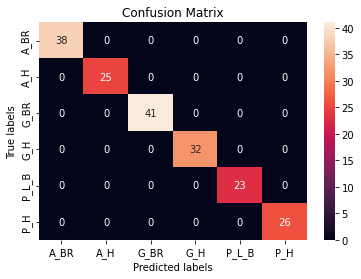

In [ ]:
# Confusion matrix with accuracy,precision, F1 for each class
def plot_confusion_matrix(main_model,testing_data):
  y_actual=np.array([])
  y_pred=np.array([])
  for x_actual1,y_actual1 in testing_data:
    y_pred1=main_model.predict(x_actual1)
    for x in y_actual1:
      y_actual=np.append(y_actual,np.argmax(x,axis=0))
    for y in y_pred1:
      y_pred=np.append(y_pred,np.argmax(y,axis=0))

  cm=confusion_matrix(y_pred,y_actual,labels=[0,1,2,3,4,5] )
  ax= plt.subplot()
  print(cm)
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['A_BR','A_H','G_BR','G_H','P_L_B','P_H']); ax.yaxis.set_ticklabels(['A_BR','A_H','G_BR','G_H','P_L_B','P_H']);
  print("Label Description:")
  print("A_BR->",class_names[0])
  print("A_H->",class_names[1])
  print("G_BR->",class_names[2])
  print("G_H->",class_names[3])
  print("P_L_B->",class_names[4])
  print("P_H->",class_names[5])
  accuracy=accuracy_score(y_actual,y_pred)
  print("accuracy of the model is",accuracy)
  other_metrics=precision_recall_fscore_support(y_actual, y_pred, average=None,labels=[0, 1, 2,3,4,5])
  print(other_metrics)
  for x in range(len(class_names)):
    precision=""+str(other_metrics[0][x])
    print("precision of "+class_names[x]+":"+precision)
    Recall=""+str(other_metrics[1][x])
    print("Recall of "+class_names[x]+":"+Recall)
    F_score=""+str(other_metrics[2][x])
    print("F-score of "+class_names[x]+":"+F_score)
  

plot_confusion_matrix(main_model1,testing_data)


Found 141 files belonging to 6 classes.
Using 133 files for validation.
[[16  0  0  0  0  0]
 [ 0 22  0  0  0  2]
 [ 0  0 22  0  0  0]
 [ 0  0  1 20  1  0]
 [ 0  0  0  0 19  0]
 [ 0  0  0  0  3 27]]
Label Description:
A_BR-> Apple_Black_rot
A_H-> Apple_healthy
G_BR-> Grape_Black_rot
G_H-> Grape_healthy
P_L_B-> Potato_Late_blight
P_H-> Potato_healthy
accuracy of the model is 0.9473684210526315
(array([1.        , 0.91666667, 1.        , 0.90909091, 1.        ,
       0.9       ]), array([1.        , 1.        , 0.95652174, 1.        , 0.82608696,
       0.93103448]), array([1.        , 0.95652174, 0.97777778, 0.95238095, 0.9047619 ,
       0.91525424]), array([16, 22, 23, 20, 23, 29]))
precision of Apple_Black_rot:1.0
Recall of Apple_Black_rot:1.0
F-score of Apple_Black_rot:1.0
precision of Apple_healthy:0.9166666666666666
Recall of Apple_healthy:1.0
F-score of Apple_healthy:0.9565217391304348
precision of Grape_Black_rot:1.0
Recall of Grape_Black_rot:0.9565217391304348
F-score of Grape

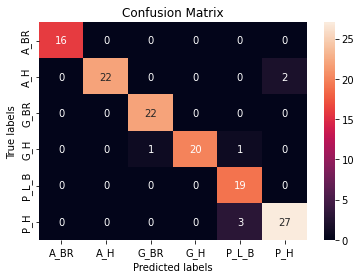

In [ ]:
# creating testing data of images with white background and confusion matrix 
img_height=224
img_width=224
batch_size=32
testing_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_without_background,
    validation_split=0.95,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)
testing_data=testing_data.map(process)
plot_confusion_matrix(main_model1,testing_data)



In [ ]:
#importing necessary libraries for image background removal
!pip install cvzone
import cvzone
!pip install mediapipe 
from cvzone.SelfiSegmentationModule import SelfiSegmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18768 sha256=346f1dc49ea7e30cee39d71cea620d7593b73bb3b24e6cbe66134d0f9a5554fb
  Stored in directory: /root/.cache/pip/wheels/c1/e8/e9/80f482161ba9f5dcf4832b76ac70540edd11a3136a58445c52
Successfully built cvzone
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 328 kB/s 


In [ ]:
# Converting normal images to images with white background
from google.colab.patches import cv2_imshow
leaf_list=os.listdir("/content/dataset_image_classification/Potato_healthy")
segmentor=SelfiSegmentation()
for x in leaf_list:
  image_path="/content/dataset_image_classification/Potato_healthy/"+x
  img=cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
  img=segmentor.removeBG(img,(255,255,255),threshold=0.5)
  cv2_imshow(img)
  img_path="/content/sample_data/without_background/Potato_healthy/"+x
  cv2.imwrite(img_path,img)
  

FileNotFoundError: ignored

# EfficientNet

In [ ]:
# Collecting Training Data For EfficientNet B1
img_height=240
img_width=240
batch_size=32
training_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_full_dataset,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)



Found 927 files belonging to 6 classes.
Using 742 files for training.


In [ ]:
# Collecting testing data for EfficientNet
testing_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_full_dataset,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)


Found 927 files belonging to 6 classes.
Using 185 files for validation.


In [ ]:
# Initialising EfficientNet and adding FCN at tail end
Efficient_net=tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height,img_width,3),
    pooling='avg',
    classes=6,
    classifier_activation="softmax"
)
main_model=Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])
for layer in Efficient_net.layers:
  layer.trainable=True
main_model.add(Efficient_net)
main_model.add(Flatten())
main_model.add(Dense(512,activation='relu'))
main_model.add(Dense(512,activation='relu'))
main_model.add(Dense(6,activation='softmax'))

main_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])




27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
Efficient_net.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
# Fitting a model or training model
import time
start = time.time()
epochs=30
history=main_model.fit(training_data,validation_data=testing_data,epochs=epochs)
end=time.time()
print("the difference in time is:",end-start)

Epoch 1/30


KeyboardInterrupt: ignored

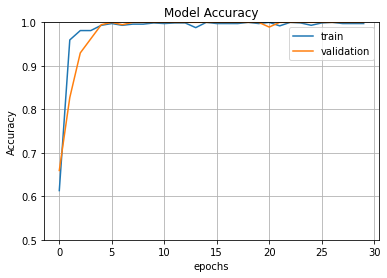

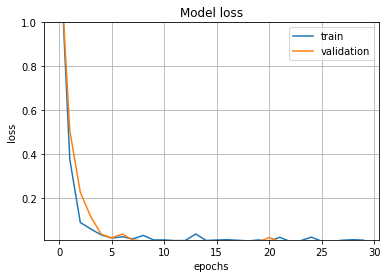

In [ ]:
# plotting loss and accuracy graph across epochs
 plot_accuracy_and_loss(history)

In [ ]:
# Loading pre-trained weights of EfficientNet
main_model.load_weights("Efficientnet_large_dataset_model.h5")

[[38  0  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 41  0  0  0]
 [ 0  0  0 32  0  0]
 [ 0  0  0  0 23  0]
 [ 0  0  0  0  0 26]]
Label Description:
A_BR-> Apple_Black_rot
A_H-> Apple_healthy
G_BR-> Grape_Black_rot
G_H-> Grape_healthy
P_L_B-> Potato_Late_blight
P_H-> Potato_healthy
accuracy of the model is 1.0
(array([1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1.]), array([38, 25, 41, 32, 23, 26]))
precision of Apple_Black_rot:1.0
Recall of Apple_Black_rot:1.0
F-score of Apple_Black_rot:1.0
precision of Apple_healthy:1.0
Recall of Apple_healthy:1.0
F-score of Apple_healthy:1.0
precision of Grape_Black_rot:1.0
Recall of Grape_Black_rot:1.0
F-score of Grape_Black_rot:1.0
precision of Grape_healthy:1.0
Recall of Grape_healthy:1.0
F-score of Grape_healthy:1.0
precision of Potato_Late_blight:1.0
Recall of Potato_Late_blight:1.0
F-score of Potato_Late_blight:1.0
precision of Potato_healthy:1.0
Recall of Potato_healthy:1.0
F-score of Potato_healthy:1.0


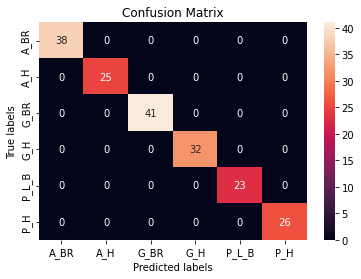

In [ ]:
# Plotting Confusion matrix and accuracy, precision, F1 score for each class
plot_confusion_matrix(main_model,testing_data)


Found 141 files belonging to 6 classes.
Using 133 files for validation.
[[ 2  0  0  0  0  0]
 [ 5 17  1  0  4  1]
 [ 1  1  0  0  0  0]
 [ 6  4 22 20 11  8]
 [ 0  0  0  0  0  0]
 [ 2  0  0  0  8 20]]
Label Description:
A_BR-> Apple_Black_rot
A_H-> Apple_healthy
G_BR-> Grape_Black_rot
G_H-> Grape_healthy
P_L_B-> Potato_Late_blight
P_H-> Potato_healthy
accuracy of the model is 0.44360902255639095
(array([1.        , 0.60714286, 0.        , 0.28169014, 0.        ,
       0.66666667]), array([0.125     , 0.77272727, 0.        , 1.        , 0.        ,
       0.68965517]), array([0.22222222, 0.68      , 0.        , 0.43956044, 0.        ,
       0.6779661 ]), array([16, 22, 23, 20, 23, 29]))
precision of Apple_Black_rot:1.0
Recall of Apple_Black_rot:0.125
F-score of Apple_Black_rot:0.2222222222222222
precision of Apple_healthy:0.6071428571428571
Recall of Apple_healthy:0.7727272727272727
F-score of Apple_healthy:0.68
precision of Grape_Black_rot:0.0
Recall of Grape_Black_rot:0.0
F-score of G

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


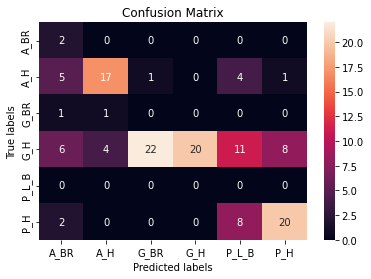

In [ ]:
# Collecting images(white background) for testing data
img_height=240
img_width=240
batch_size=32
testing_data=tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_without_background,
    validation_split=0.95,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)

plot_confusion_matrix(main_model,testing_data)
